## Imports y data load

In [1]:
#imports

import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, make_scorer, f1_score, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

# Modelo binario

In [2]:
df_int_binario = pd.read_csv('../data/base_procesada_binaria.csv')
df_int_binario.head()

,Estudios_máximos_antes_de_la_inscripción,estado_civil,sexo,desplazado,Asistencia_diurna/nocturna,Cualificación_promedio_de_estudios_previos,Puntaje_en_examen_de_ingreso,Necesidades_educativas_especiales,Tiene_deuda,Pago_de_matrícula_al_día,...,Carrera_Gestión,Carrera_Ingeniería Informática,Carrera_Periodismo y Comunicación,Carrera_Psicología,Carrera_Publicidad y Marketing,Carrera_Química,Carrera_Sociología,Carrera_Turismo,Carrera_Veterinaria,target_binaria
0,3,1,0,0,1,66,65,0,0,1,...,0,0,0,0,0,0,0,0,0,1
1,3,1,0,1,1,69,66,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,3,1,0,1,1,69,63,0,0,1,...,0,0,0,0,0,0,0,0,0,1
3,4,1,0,1,1,68,68,0,0,1,...,0,0,0,0,0,0,0,0,0,1
4,3,1,1,1,1,68,70,0,0,1,...,0,0,1,0,0,0,0,0,0,1


In [3]:
# Separar features y target
X = df_int_binario.drop('target_binaria', axis=1)
y = df_int_binario['target_binaria']

# Dividir en train y test
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


### Regresión logística

In [4]:
# Escalar los datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Crear y entrenar el modelo
modelo_lr = LogisticRegression(
    class_weight='balanced',
    random_state=42,
    max_iter=10000
)

# Entrenar con datos escalados
modelo_lr.fit(X_train_scaled, y_train)

# Ambas predicciones con datos escalados
y_pred = modelo_lr.predict(X_test_scaled)
y_pred_proba = modelo_lr.predict_proba(X_test_scaled)


Accuracy: 0.8519

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.80      0.82      0.81      4365
           1       0.89      0.87      0.88      7137

    accuracy                           0.85     11502
   macro avg       0.84      0.85      0.84     11502
weighted avg       0.85      0.85      0.85     11502



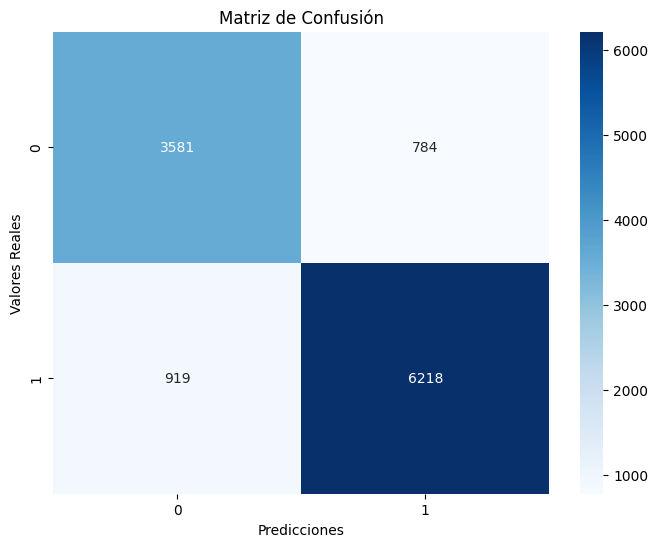

In [5]:
# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Reporte de clasificación
print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred))

# Matriz de confusión
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión')
plt.ylabel('Valores Reales')
plt.xlabel('Predicciones')
plt.show()


In [6]:
# Obtener los coeficientes del modelo
coeficientes = modelo_lr.coef_  # o modelo_lr según cuál uses
feature_names = X_train.columns

# Para multiclase, tenemos coeficientes para cada clase
n_classes = len(modelo_lr.classes_)
print(f"Clases: {modelo_lr.classes_}")
print(f"Shape coeficientes: {coeficientes.shape}")

# Calcular importancia absoluta promedio
importancia_abs = np.mean(np.abs(coeficientes), axis=0)

# Crear DataFrame con importancias
feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importancia_abs
}).sort_values('importance', ascending=False)

print("\nTop Features más importantes:")
print(feature_importance_df.head(50))

Clases: [0 1]
Shape coeficientes: (1, 41)

Top Features más importantes:
                                           feature  importance
19  Unidades_curriculares_2do_semestre_(aprobadas)    1.477590
15  Unidades_curriculares_1er_semestre_(aprobadas)    0.743379
17   Unidades_curriculares_2do_semestre_(inscrito)    0.600794
9                         Pago_de_matrícula_al_día    0.489162
20                Nota_promedio_en_el_2do_semestre    0.422675
10                                Poseedor_de_Beca    0.370435
13   Unidades_curriculares_1er_semestre_(inscrito)    0.349601
18    Cantidad_de_evaluaciones_en_el_2do_semestre_    0.300134
16                Nota_promedio_en_el_1er_semestre    0.295537
26                                 Carrera_Derecho    0.292029
33                  Carrera_Ingeniería Informática    0.256290
35                              Carrera_Psicología    0.216918
14     Cantidad_de_evaluaciones_en_el_1er_semestre    0.209818
8                                      Tiene_

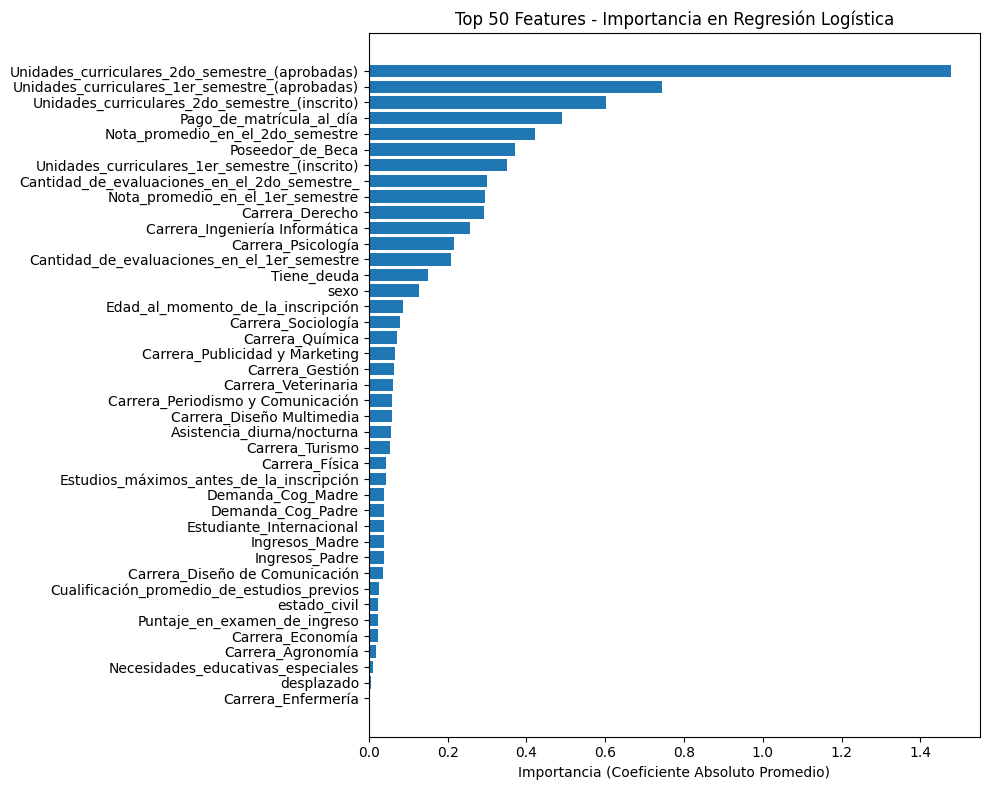

In [7]:
# Plot de las top features
plt.figure(figsize=(10, 8))
top_features = feature_importance_df.head(50)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Importancia (Coeficiente Absoluto Promedio)')
plt.title('Top 50 Features - Importancia en Regresión Logística')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

#### smote, para manejo de desbalance


Accuracy con SMOTE: 0.8523

Reporte de Clasificación con SMOTE:
              precision    recall  f1-score   support

           0       0.80      0.82      0.81      4365
           1       0.89      0.87      0.88      7137

    accuracy                           0.85     11502
   macro avg       0.84      0.85      0.84     11502
weighted avg       0.85      0.85      0.85     11502



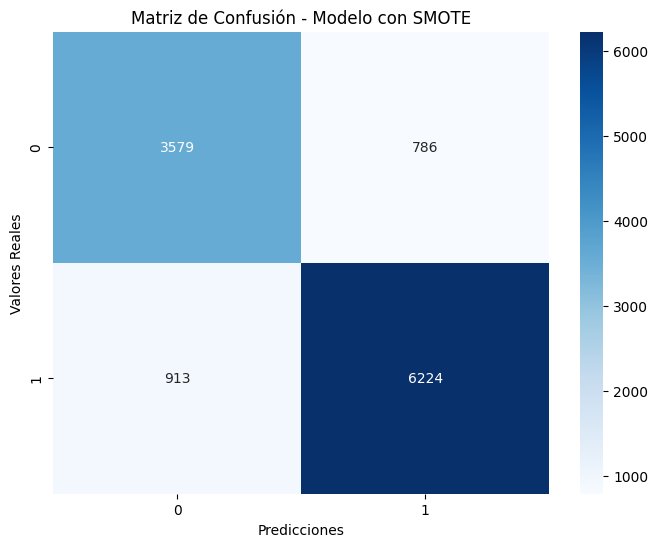

In [8]:
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression

# 1. Escalar los datos ANTES de SMOTE
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 2. Aplicar SMOTE a los datos escalados
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

# 3. Entrenar modelo
modelo_lr_smote = LogisticRegression(
    random_state=42,
    max_iter=10000  # Mantener el valor actual
)

modelo_lr_smote.fit(X_train_smote, y_train_smote)

# 4. Predicciones (usar datos escalados)
y_pred_smote = modelo_lr_smote.predict(X_test_scaled)
y_pred_proba_smote = modelo_lr_smote.predict_proba(X_test_scaled)

# Evaluación
accuracy_smote = accuracy_score(y_test, y_pred_smote)
print(f"\nAccuracy con SMOTE: {accuracy_smote:.4f}")

print("\nReporte de Clasificación con SMOTE:")
print(classification_report(y_test, y_pred_smote))

# Matriz de confusión
plt.figure(figsize=(8, 6))
cm_smote = confusion_matrix(y_test, y_pred_smote)
sns.heatmap(cm_smote, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión - Modelo con SMOTE')
plt.ylabel('Valores Reales')
plt.xlabel('Predicciones')
plt.show()

### Máquina de vectores de soporte (SVM) 

In [9]:
from sklearn.svm import SVC

# Crea el modelo SVM sin SMOTEs
modelo_svm = SVC(kernel='linear', C=1, random_state=42)

# Entrenar el modelo con los datos de train escalados
modelo_svm.fit(X_train_scaled, y_train)

# Predicciones
y_pred_svm = modelo_svm.predict(X_test_scaled)

Accuracy SVM: 0.8584
Accuracy de la clasificación: 85.19%

Reporte de Clasificación SVM:
              precision    recall  f1-score   support

           0       0.85      0.76      0.80      4365
           1       0.86      0.92      0.89      7137

    accuracy                           0.86     11502
   macro avg       0.86      0.84      0.85     11502
weighted avg       0.86      0.86      0.86     11502



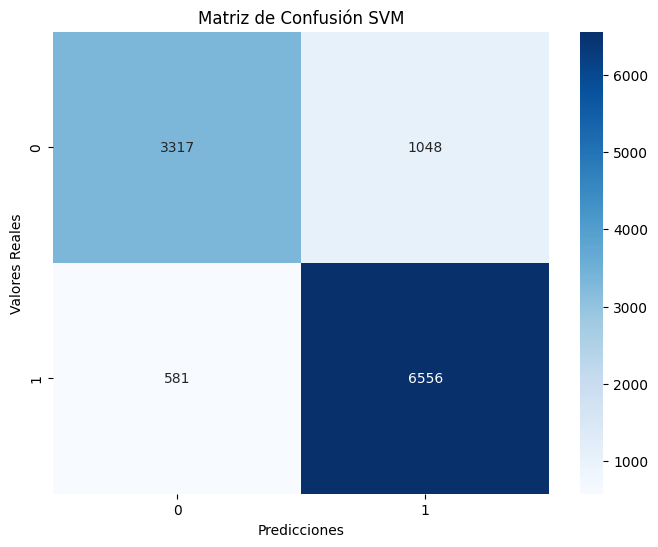

In [10]:
# --- Evaluación SVM sin SMOTE ---
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print(f"Accuracy SVM: {accuracy_svm:.4f}")
print("Accuracy de la clasificación: {:.2f}%".format(accuracy * 100))

print("\nReporte de Clasificación SVM:")
print(classification_report(y_test, y_pred_svm))

# Matriz de confusión
plt.figure(figsize=(8, 6))
cm_svm = confusion_matrix(y_test, y_pred_svm)
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión SVM')
plt.ylabel('Valores Reales')
plt.xlabel('Predicciones')
plt.show()

#### smote

In [11]:
from sklearn.svm import SVC

# Crear el modelo SVM con smote
# SVM con SMOTE
modelo_svm_smote = SVC(
    kernel='linear', #"rfb"
    #class_weight='balanced',
    probability=True,
    random_state=42
)
modelo_svm_smote.fit(X_train_smote, y_train_smote)
y_pred_svm_smote = modelo_svm_smote.predict(X_test_scaled)
y_pred_svm_smote_proba = modelo_svm_smote.predict_proba(X_test_scaled)


Accuracy SVM con SMOTE: 0.8533

Reporte de Clasificación SVM con SMOTE:
              precision    recall  f1-score   support

           0       0.80      0.81      0.81      4365
           1       0.89      0.88      0.88      7137

    accuracy                           0.85     11502
   macro avg       0.84      0.85      0.84     11502
weighted avg       0.85      0.85      0.85     11502



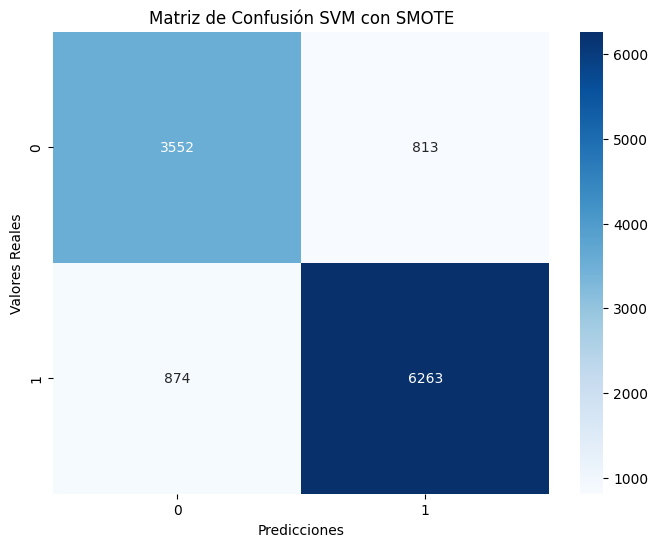

In [12]:
#Evaluacion matriz confusion SVM con SMOTE
accuracy_svm_smote = accuracy_score(y_test, y_pred_svm_smote)
print(f"\nAccuracy SVM con SMOTE: {accuracy_svm_smote:.4f}")

print("\nReporte de Clasificación SVM con SMOTE:")
print(classification_report(y_test, y_pred_svm_smote))

# Matriz de confusión
plt.figure(figsize=(8, 6))
cm_svm_smote = confusion_matrix(y_test, y_pred_svm_smote)
sns.heatmap(cm_svm_smote, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión SVM con SMOTE')
plt.ylabel('Valores Reales')
plt.xlabel('Predicciones')
plt.show()

### Árboles de Decisión 


In [13]:
#Modelo Random forest sin smote
### Random Forest sin SMOTE     
from sklearn.ensemble import RandomForestClassifier
modelo_rf = RandomForestClassifier(
    n_estimators=100,
    class_weight='balanced',
    random_state=42
)
modelo_rf.fit(X_train_scaled, y_train)
y_pred_rf = modelo_rf.predict(X_test_scaled)    
#Evaluacion matriz confusion Random Forest sin SMOTE
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"\nAccuracy Random Forest: {accuracy_rf:.4f}")


Accuracy Random Forest: 0.8583


Accuracy de la clasificación: 85.83%

Reporte de Clasificación Random Forest:
              precision    recall  f1-score   support

           0       0.84      0.77      0.80      4365
           1       0.87      0.91      0.89      7137

    accuracy                           0.86     11502
   macro avg       0.85      0.84      0.85     11502
weighted avg       0.86      0.86      0.86     11502



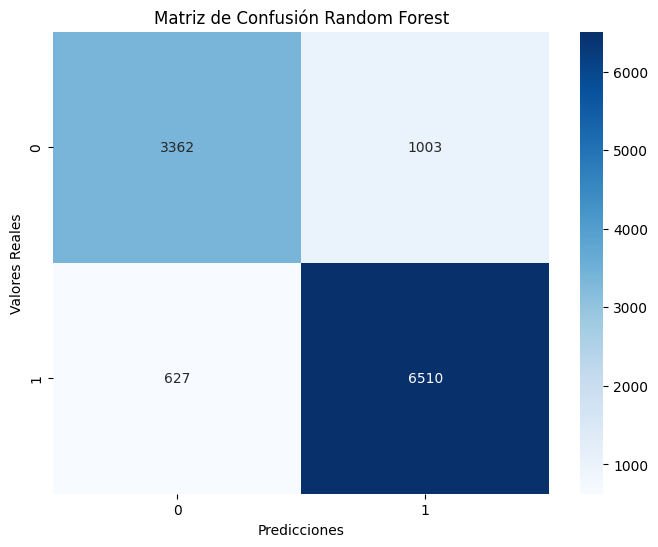

In [14]:
#Accuracy RF sin smote
print("Accuracy de la clasificación: {:.2f}%".format(accuracy_rf * 100))

#matriz de confusion RF sin smote
print("\nReporte de Clasificación Random Forest:")  
print(classification_report(y_test, y_pred_rf))
# Matriz de confusión
plt.figure(figsize=(8, 6))
cm_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión Random Forest')
plt.ylabel('Valores Reales')
plt.xlabel('Predicciones')
plt.show()


#### smote

In [15]:
#Generar modelo con random forest
from sklearn.ensemble import RandomForestClassifier

modelo_rf_smote = RandomForestClassifier(
    n_estimators=500,
    max_depth=6,
    random_state=42
)

modelo_rf_smote.fit(X_train_smote, y_train_smote)
y_pred_rf_smote = modelo_rf_smote.predict(X_test_scaled)    



Accuracy RF con SMOTE: 0.8476

Reporte de Clasificación RF con SMOTE:
              precision    recall  f1-score   support

           0       0.80      0.79      0.80      4365
           1       0.87      0.88      0.88      7137

    accuracy                           0.85     11502
   macro avg       0.84      0.84      0.84     11502
weighted avg       0.85      0.85      0.85     11502

Accuracy de la clasificación: 84.76%


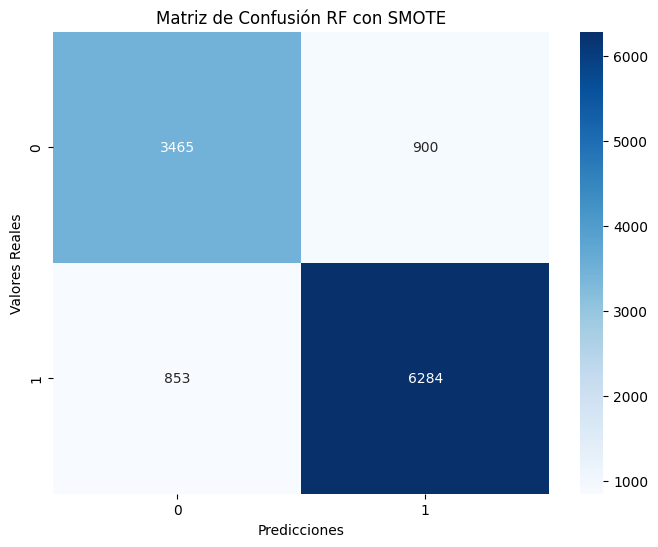

In [16]:
#Accuracy RF con SMOTE
accuracy_rf = accuracy_score(y_test, y_pred_rf_smote)
print(f"\nAccuracy RF con SMOTE: {accuracy_rf:.4f}")

#reporte de clasificación RF con SMOTE
print("\nReporte de Clasificación RF con SMOTE:")
print(classification_report(y_test, y_pred_rf_smote))
print("Accuracy de la clasificación: {:.2f}%".format(accuracy_rf * 100))

#matriz de confusión RF con SMOTE
plt.figure(figsize=(8, 6))
cm_rf = confusion_matrix(y_test, y_pred_rf_smote    )
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión RF con SMOTE')
plt.ylabel('Valores Reales')
plt.xlabel('Predicciones')
plt.show()

#### Optuna para RF sin SMOTE

In [17]:
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

def objective(trial):
    # Definimos el espacio de búsqueda de hiperparámetros
    n_estimators = trial.suggest_int("n_estimators", 50, 300)
    max_depth = trial.suggest_int("max_depth", 2, 20)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 20)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 10)
    max_features = trial.suggest_categorical("max_features", ["sqrt", "log2", None])
    
    # Definir el modelo
    modelo = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        class_weight="balanced",
        random_state=42,
        n_jobs=-1
    )
    
    # Entrenar con los datos escalados sin SMOTE
    modelo.fit(X_train_scaled, y_train)
    y_pred = modelo.predict(X_test_scaled)
    
    # Calcular accuracy
    acc = accuracy_score(y_test, y_pred)
    return acc

# Crear el estudio
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)  # podés subir n_trials (ej: 100) si tenés tiempo

# Mostrar los mejores parámetros y el mejor score
print("Mejores hiperparámetros:", study.best_params)
print("Mejor accuracy:", study.best_value)


/Users/sofiaforni/Documents/FCEN UBA Maestria/aprendizaje automatico 2025/aprendizaje_automatico_desertores/venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-10-06 23:09:20,226] A new study created in memory with name: no-name-9634ba01-4115-4494-9696-8ad50eefb10d
[I 2025-10-06 23:09:21,041] Trial 0 finished with value: 0.8310728568944531 and parameters: {'n_estimators': 251, 'max_depth': 2, 'min_samples_split': 20, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.8310728568944531.
[I 2025-10-06 23:09:21,481] Trial 1 finished with value: 0.8422013562858633 and parameters: {'n_estimators': 127, 'max_depth': 5, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.8422013562858633.
[I 2025-10-06 23:09:25,841] Trial 2 fi

Mejores hiperparámetros: {'n_estimators': 157, 'max_depth': 19, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': 'log2'}
Mejor accuracy: 0.8607198748043818


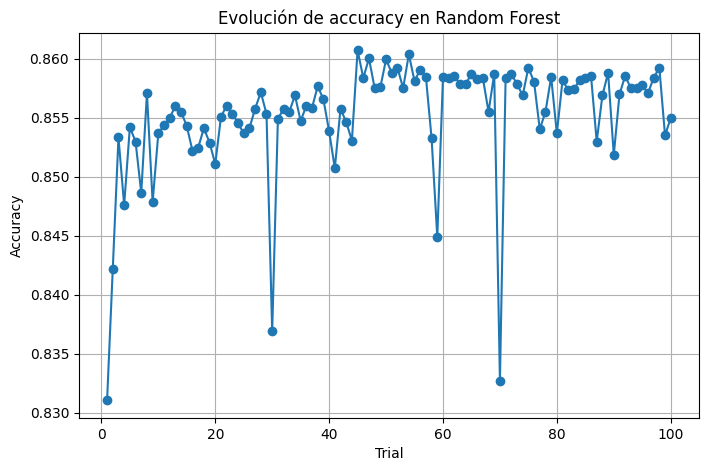

In [18]:
import matplotlib.pyplot as plt

# Extraer los valores de accuracy de cada trial
accuracies = [t.value for t in study.trials]

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(accuracies)+1), accuracies, marker='o')
plt.title("Evolución de accuracy en Random Forest")
plt.xlabel("Trial")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()


## VOTING

In [19]:
from imblearn.pipeline import Pipeline 
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC

In [20]:
# Escalar los datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [21]:
#Pipeline permite encadenar múltiples pasos de procesamiento o modelos en un solo objeto.
#Con esta función le pido crear cada versión con y sin SMOTE de Regresión, SVM y RF.
#Yo voy a hacer que se vote entre todas las combinaciones posibles pero se podría hacer una votación entre modelos con smote y una votación entre modelos sin smote.

pipe_lr = Pipeline([('lr', LogisticRegression(random_state=42, class_weight='balanced', max_iter=10000))])
pipe_lr_smote = Pipeline([('smote', SMOTE(random_state=42)),('lr', LogisticRegression(random_state=42, max_iter=10000))])

pipe_svm = Pipeline([('svm', SVC(probability=True, random_state=42, kernel='linear', C=1))])
pipe_svm_smote = Pipeline([('smote', SMOTE(random_state=42)),('svm', SVC(probability=True, random_state=42, kernel='linear'))])

pipe_rf = Pipeline([('rf', RandomForestClassifier(random_state=42, n_estimators=100, class_weight='balanced',))])
pipe_rf_smote = Pipeline([('smote', SMOTE(random_state=42)),('rf', RandomForestClassifier(random_state=42, n_estimators=500, max_depth=6))])


voting_clf = VotingClassifier(
    estimators=[
        ('lr', pipe_lr),            
        ('lr_smote', pipe_lr_smote),
        ('svm', pipe_svm),
        ('svm_smote', pipe_svm_smote),
        ('rf', pipe_rf),
        ('rf_smote', pipe_rf_smote)], voting='hard')    #SOFT PARA PREDICCIÓN DE PROBA. HARD PARA PREDICCIÓN DE CLASE.


#voting concatena la información de todas las salidas para predecir.
voting_clf.fit(X_train_scaled, y_train)

,estimators,"[('lr', ...), ('lr_smote', ...), ...]"
,voting,'hard'
,weights,None
,n_jobs,None
,flatten_transform,True
,verbose,False
,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True


In [22]:
print(f"Accuracy training : {voting_clf.score(X_train_scaled, y_train):.3f}")
print(f"Accuracy test: {voting_clf.score(X_test_scaled, y_test):.3f}")

Accuracy training : 0.858
Accuracy test: 0.854


VOTING CLASSIFIER - RESULTADO FINAL
              precision    recall  f1-score   support

           0       0.80      0.82      0.81      4365
           1       0.89      0.88      0.88      7137

    accuracy                           0.85     11502
   macro avg       0.84      0.85      0.85     11502
weighted avg       0.85      0.85      0.85     11502



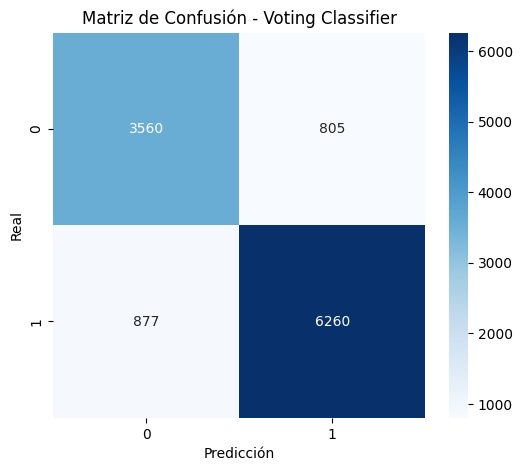

In [23]:
# Predicciones del voting classifier
y_pred_voting = voting_clf.predict(X_test_scaled)

print("VOTING CLASSIFIER - RESULTADO FINAL")
print("="*60)
print(classification_report(y_test, y_pred_voting))

# Matriz de confusión
cm_voting = confusion_matrix(y_test, y_pred_voting)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_voting, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión - Voting Classifier')
plt.ylabel('Real')
plt.xlabel('Predicción')
plt.show()

## Boosting

In [24]:
# Tu modelo multiclase
model = lgb.LGBMClassifier(
    objective='binary',
    max_depth=5,
    learning_rate=0.1,
    n_estimators=100,
    random_state=42,
    verbose=-1 
)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Evaluar
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(classification_report(y_test, y_pred))

Accuracy: 0.8628
              precision    recall  f1-score   support

           0       0.85      0.77      0.81      4365
           1       0.87      0.92      0.89      7137

    accuracy                           0.86     11502
   macro avg       0.86      0.85      0.85     11502
weighted avg       0.86      0.86      0.86     11502

